## Bare pretrained Resnet backbone evaluation

In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import cohen_kappa_score, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import os
from torchsummary import summary
import numpy as np
from torch.nn import functional as F

BATCH = 32
label_names = ["D", "G", "A"]
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet_dir = "../pretrained_backbone/ckpt_resnet18_ep50.pt"

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_images= "../images/train"
train_labels = "../train.csv"
val_images = "../images/val"
val_labels = "../val.csv"
offsite_test_images = "../images/offsite_test"
offsite_test_labels = "../offsite_test.csv"
onsite_test_images = "../images/onsite_test"
onsite_test_labels = "../onsite_test_submission.csv"

### Uncomment on colab

In [3]:
'''
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Projects/ODIR/task2_loss")
'''

'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n\nimport os\nos.chdir("/content/drive/MyDrive/Projects/ODIR/task2_loss")\n'

## Datasets

In [4]:
class RetinaMultiLabelDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row.iloc[0])
        img = Image.open(img_path).convert("RGB")
        labels = torch.tensor(row[1:].values.astype("float32"))
        if self.transform:
            img = self.transform(img)
        return img, labels

### Image transform

In [5]:
img_size=256
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [6]:
train = RetinaMultiLabelDataset(train_labels, train_images, transform = transform)
val = RetinaMultiLabelDataset(val_labels, val_images, transform = transform)
offsite_test = RetinaMultiLabelDataset(offsite_test_labels, offsite_test_images, transform = transform)
onsite_test = RetinaMultiLabelDataset(onsite_test_labels, onsite_test_images, transform = transform)


### Model

In [7]:

class Classifier(nn.Module):
    def __init__(self, backbone = "resnet", dir = None):
        super().__init__()

        if dir == None:
            raise FileNotFoundError
        layers = torch.load(dir)

        if backbone == "resnet":
            self.model = models.resnet18()
            self.model.fc = nn.Linear(self.model.fc.in_features, 3)
        elif backbone == "efficientnet":
            self.model = models.efficientnet_b0()
            self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 3)
        else:
            raise ValueError("Unsupported backbone")
        self.model.load_state_dict(layers)

    def forward(self, X):
        return self.model(X)

model = Classifier(backbone="resnet", dir = resnet_dir).to(device)

In [8]:
def eval_model(model, dataset, csv_file = None, report = False):

    loader = DataLoader(dataset, BATCH, shuffle=False)
    preds = []
    model.eval()

    with torch.no_grad():
      for X, _ in tqdm(loader):
          output = (nn.functional.sigmoid(model(X.to(device))) > 0.5).long()
          preds.extend(output.cpu().numpy())

    preds = np.stack(preds)
    if report:
        cr = classification_report(dataset.data[label_names].to_numpy(), preds, target_names=label_names, zero_division= np.nan)
        print(cr)
    if csv_file:
        data = dataset.data.copy()
        data[label_names] = preds
        data.to_csv(csv_file, index = False)

## Fine-tuning classifier first

In [9]:
params = model.parameters()
for layer in params:
        layer.requires_grad = False
for param in model.model.fc.parameters():
        param.requires_grad = True

In [10]:
checkpoints_dir = "../trained_models/"


def train_model(model, train_data, eval_data, optimizer, criterion, epochs, stepLR = None, checkpoint_name = None):
    train_loader = DataLoader(train_data,  BATCH, shuffle=True)
    val_loader = DataLoader(eval_data, BATCH, shuffle=False)
    train_size = len(train_data.data)
    eval_size = len(eval_data.data)

    train_losses = []
    val_losses = []

    f1 = []
    accuracy = []
    best_score = np.inf
    for i in range(epochs):
        model.train()
        train_loss = 0
        val_loss = 0
        val_f1 = 0
        val_accuracy = 0

        for (X, Y) in tqdm(train_loader, desc = "Training"):
            if device == "cuda":
                X = X.to(device)
                Y = Y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)

        train_loss = train_loss / train_size

        model.eval()
        with torch.no_grad():
            for (X, Y) in tqdm(val_loader, desc="Validation"):
                if device == "cuda":
                    X = X.to(device)
                    Y = Y.to(device)
                output = model(X)
                loss = criterion(output, Y)
                val_loss += loss.item() * X.size(0)
                output = nn.functional.sigmoid(output)
                val_accuracy += accuracy_score((output > 0.5).cpu().long().numpy(), Y.cpu().numpy())
                val_f1 += f1_score((output > 0.5).cpu().long().numpy(), Y.cpu().numpy(),average='samples')

        val_loss = val_loss / eval_size
        val_accuracy /= np.ceil(eval_size/BATCH)
        val_f1 /= np.ceil(eval_size/BATCH)

        print(f"Epoch: {i} - Train Loss: {train_loss:2f} - Val Loss: {val_loss:2f} - Val Accuracy: {val_accuracy:2f} - Val F1 (avg. samples): {val_f1:2f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        #saving model if score imporved
        if best_score > val_loss :
            print("Model improved! Saving if checkpoint_name is set.")
            best_score = val_loss
            if checkpoint_name != None:
                torch.save(model.state_dict(), checkpoints_dir + checkpoint_name)
        f1.append(val_f1)
        accuracy.append(val_accuracy)
        if stepLR != None:
                stepLR.step()

    x = range(0, epochs)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, train_losses, label = "Train Loss")
    plt.plot(x, val_losses, label = "Val Loss")
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.title("BCE Loss")
    plt.subplot(1, 3, 2)
    plt.plot(x, f1)
    plt.title("Val F1 (avg. samples)")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.subplot(1, 3, 3)
    plt.plot(x, accuracy)
    plt.title("Val accuracy")
    plt.ylabel("Metric")
    plt.xlabel("Epoch")
    plt.show()

    return train_losses, val_losses, f1, accuracy

In [ ]:
class ClassBalancedLoss(nn.Module):

    def __init__(self, dataset):
        super().__init__()
        assert dataset is not None, "You must provide the training dataset."
        
        pos = dataset.data[label_names].sum(axis = 0).to_numpy()
        neg = len(train.data) - pos
        self.weights = torch.tensor(neg / pos,  dtype=torch.float32, device=device)

    def forward(self, inputs, targets):
        return F.binary_cross_entropy_with_logits(inputs, targets, weight=self.weights, reduction="mean")

lr=1e-3 was the best

Validation: 100%|██████████| 7/7 [00:00<00:00,  8.54it/s]


Epoch: 0 - Train Loss: 2.215789 - Val Loss: 1.939759 - Val Accuracy: 0.334821 - Val F1 (avg. samples): 0.467262
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch: 1 - Train Loss: 1.512295 - Val Loss: 1.620631 - Val Accuracy: 0.482143 - Val F1 (avg. samples): 0.541667
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.47it/s]


Epoch: 2 - Train Loss: 1.317585 - Val Loss: 1.489728 - Val Accuracy: 0.504464 - Val F1 (avg. samples): 0.569940
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.50it/s]


Epoch: 3 - Train Loss: 1.272593 - Val Loss: 1.423891 - Val Accuracy: 0.513393 - Val F1 (avg. samples): 0.581845
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.18it/s]


Epoch: 4 - Train Loss: 1.276017 - Val Loss: 1.421961 - Val Accuracy: 0.500000 - Val F1 (avg. samples): 0.595238
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.53it/s]


Epoch: 5 - Train Loss: 1.257275 - Val Loss: 1.456298 - Val Accuracy: 0.495536 - Val F1 (avg. samples): 0.578869


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.96it/s]


Epoch: 6 - Train Loss: 1.242825 - Val Loss: 1.444667 - Val Accuracy: 0.508929 - Val F1 (avg. samples): 0.568452


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.00it/s]


Epoch: 7 - Train Loss: 1.244867 - Val Loss: 1.417740 - Val Accuracy: 0.513393 - Val F1 (avg. samples): 0.569940
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.32it/s]


Epoch: 8 - Train Loss: 1.232989 - Val Loss: 1.418086 - Val Accuracy: 0.522321 - Val F1 (avg. samples): 0.593750


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.50it/s]


Epoch: 9 - Train Loss: 1.208739 - Val Loss: 1.458669 - Val Accuracy: 0.522321 - Val F1 (avg. samples): 0.587798


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.48it/s]


Epoch: 10 - Train Loss: 1.200143 - Val Loss: 1.372837 - Val Accuracy: 0.531250 - Val F1 (avg. samples): 0.605655
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.55it/s]


Epoch: 11 - Train Loss: 1.215236 - Val Loss: 1.390858 - Val Accuracy: 0.508929 - Val F1 (avg. samples): 0.583333


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.44it/s]


Epoch: 12 - Train Loss: 1.191747 - Val Loss: 1.389683 - Val Accuracy: 0.508929 - Val F1 (avg. samples): 0.586310


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Epoch: 13 - Train Loss: 1.175709 - Val Loss: 1.364375 - Val Accuracy: 0.522321 - Val F1 (avg. samples): 0.605655
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.05it/s]


Epoch: 14 - Train Loss: 1.176361 - Val Loss: 1.421177 - Val Accuracy: 0.513393 - Val F1 (avg. samples): 0.608631


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.48it/s]


Epoch: 15 - Train Loss: 1.162601 - Val Loss: 1.414157 - Val Accuracy: 0.522321 - Val F1 (avg. samples): 0.629464


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.50it/s]


Epoch: 16 - Train Loss: 1.169359 - Val Loss: 1.371344 - Val Accuracy: 0.531250 - Val F1 (avg. samples): 0.605655


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.15it/s]


Epoch: 17 - Train Loss: 1.174244 - Val Loss: 1.382913 - Val Accuracy: 0.522321 - Val F1 (avg. samples): 0.599702


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.51it/s]


Epoch: 18 - Train Loss: 1.161886 - Val Loss: 1.377322 - Val Accuracy: 0.526786 - Val F1 (avg. samples): 0.619048


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.35it/s]


Epoch: 19 - Train Loss: 1.163328 - Val Loss: 1.396775 - Val Accuracy: 0.531250 - Val F1 (avg. samples): 0.617560


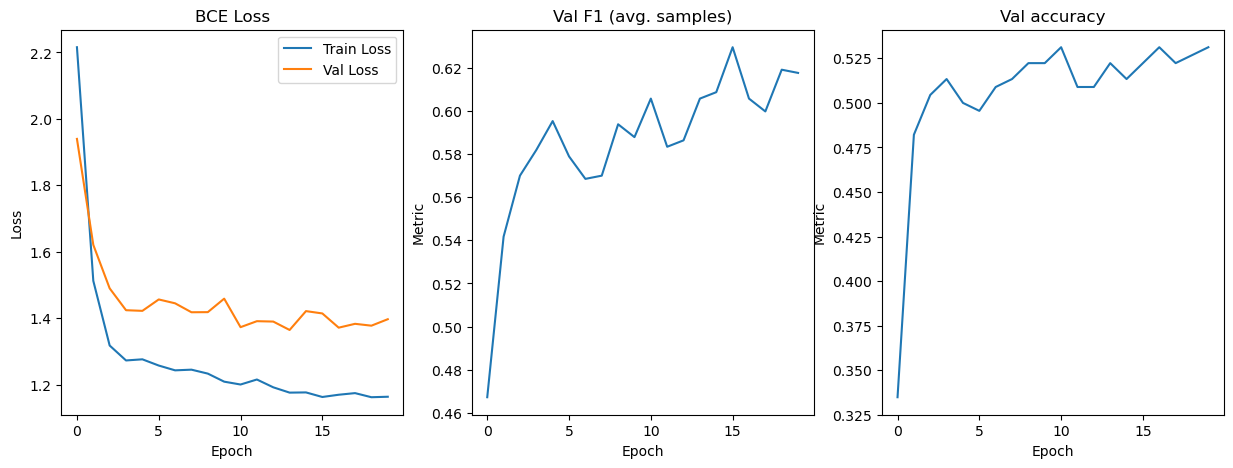

In [12]:
optimizer = torch.optim.AdamW(model.model.fc.parameters(), lr = 1e-3, weight_decay=1e-4)
criterion = ClassBalancedLoss(train).to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10, gamma=0.8)
result = train_model(model, train, val, optimizer, criterion, epochs=20, stepLR=scheduler, checkpoint_name="resnet_tuned_classifer_cb.pt")

### Offsite test

In [13]:
model.load_state_dict(torch.load(checkpoints_dir + "resnet_tuned_classifer_cb.pt"))
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:00<00:00,  9.01it/s]


              precision    recall  f1-score   support

           D       0.79      0.91      0.84       140
           G       0.78      0.29      0.42        49
           A       0.80      0.36      0.50        22

   micro avg       0.79      0.71      0.74       211
   macro avg       0.79      0.52      0.59       211
weighted avg       0.79      0.71      0.71       211
 samples avg       0.79      0.72      0.72       211



## Full fine-tuning

Only 3 epochs no more, usually overfits after epoch 1, lr = 1e-4 seem to be most optimal, no weight decay

Validation: 100%|██████████| 7/7 [00:00<00:00,  8.32it/s]


Epoch: 0 - Train Loss: 1.023953 - Val Loss: 1.317666 - Val Accuracy: 0.580357 - Val F1 (avg. samples): 0.702381
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.57it/s]


Epoch: 1 - Train Loss: 0.546703 - Val Loss: 1.050085 - Val Accuracy: 0.633929 - Val F1 (avg. samples): 0.750000
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]


Epoch: 2 - Train Loss: 0.302675 - Val Loss: 1.037009 - Val Accuracy: 0.629464 - Val F1 (avg. samples): 0.748512
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.34it/s]


Epoch: 3 - Train Loss: 0.232776 - Val Loss: 1.069177 - Val Accuracy: 0.629464 - Val F1 (avg. samples): 0.745536


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.26it/s]


Epoch: 4 - Train Loss: 0.205498 - Val Loss: 1.064728 - Val Accuracy: 0.633929 - Val F1 (avg. samples): 0.752976


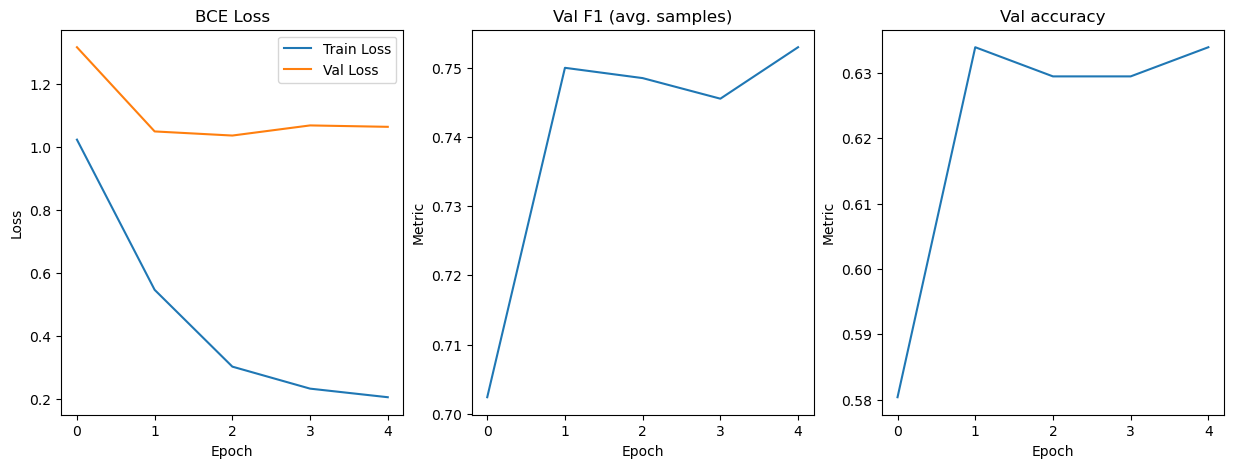

In [ ]:
for layer in model.parameters():
    layer.requires_grad = True
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.3) #torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.3)
result = train_model(model, train, val, optimizer=optimizer, criterion=criterion, epochs=5, stepLR=scheduler, checkpoint_name="resnet_cb.pt")

### Offsite

In [15]:
model.load_state_dict(torch.load(checkpoints_dir + "resnet_cb.pt"))
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:00<00:00,  8.53it/s]


              precision    recall  f1-score   support

           D       0.89      0.91      0.90       140
           G       0.87      0.67      0.76        49
           A       0.78      0.64      0.70        22

   micro avg       0.87      0.82      0.85       211
   macro avg       0.84      0.74      0.79       211
weighted avg       0.87      0.82      0.84       211
 samples avg       0.88      0.84      0.85       211



### Onsite test
![](efficientnet_classifier_full.png)

In [16]:
eval_model(model, onsite_test, "resnet_submission_full_cb.csv")

100%|██████████| 8/8 [00:01<00:00,  7.91it/s]


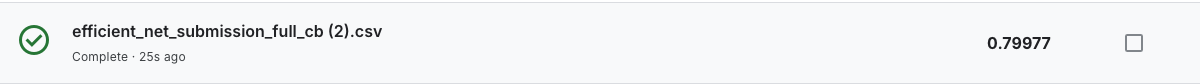